In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2

# Importing Deep Learning Libraries
from sklearn.metrics import classification_report
from keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from keras.layers import concatenate

In [2]:
!unzip 'preprocessed_dataset.zip'

Archive:  preprocessed_dataset.zip
  inflating: preprocessed_dataset/X_test.npy  
  inflating: preprocessed_dataset/X_train.npy  
  inflating: preprocessed_dataset/y_test.npy  
  inflating: preprocessed_dataset/y_train.npy  


In [3]:
# Load the preprocessed dataset from the folder
X_train = np.load('/content/preprocessed_dataset/X_train.npy')
y_train = np.load('/content/preprocessed_dataset/y_train.npy')
X_test = np.load('/content/preprocessed_dataset/X_test.npy')
y_test = np.load('/content/preprocessed_dataset/y_test.npy')

In [4]:
#split images in four parts
import numpy as np

def split_data(images):
    num_images, height, width, channels = images.shape

    # Create an array to store the split images
    split_images = np.empty((num_images, height // 2, width // 2, channels * 4), dtype=np.float32)

    for i, img in enumerate(images):
        # Split the image into four equal parts
        upper_left = img[:24, :24]
        upper_right = img[:24, 24:]
        lower_left = img[24:, :24]
        lower_right = img[24:, 24:]

        # Concatenate the four parts along the channel axis
        split_img = np.concatenate([upper_left, upper_right, lower_left, lower_right], axis=2)

        # Store the split image in the array
        split_images[i] = split_img

    return split_images

# Load the preprocessed dataset
X_train = np.load('/content/preprocessed_dataset/X_train.npy')
X_test = np.load('/content/preprocessed_dataset/X_test.npy')

# Split the training images
X_train_split = split_data(X_train)

# Split the testing images
X_test_split = split_data(X_test)

# Print the shapes of the split data
print("X_train_split shape:", X_train_split.shape)
print("X_test_split shape:", X_test_split.shape)





X_train_split shape: (28709, 24, 24, 4)
X_test_split shape: (3589, 24, 24, 4)


In [5]:
# Define the input shape for the model
num_classes = 7

# Create the Two-Stream CNN model
model = Sequential()

In [6]:
#Stream 1 (Spatial stream)
#1st CNN layer
conv_a = Sequential()
conv_a.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
conv_a.add(BatchNormalization())
conv_a.add(Activation('relu'))
conv_a.add(MaxPooling2D(pool_size = (2,2)))
conv_a.add(Dropout(0.25))

#2nd CNN layer
conv_a.add(Conv2D(128,(5,5),padding = 'same'))
conv_a.add(BatchNormalization())
conv_a.add(Activation('relu'))
conv_a.add(MaxPooling2D(pool_size = (2,2)))
conv_a.add(Dropout (0.25))

#3rd CNN layer
conv_a.add(Conv2D(512,(3,3),padding = 'same'))
conv_a.add(BatchNormalization())
conv_a.add(Activation('relu'))
conv_a.add(MaxPooling2D(pool_size = (2,2)))
conv_a.add(Dropout (0.25))

#4th CNN layer
conv_a.add(Conv2D(512,(3,3), padding='same'))
conv_a.add(BatchNormalization())
conv_a.add(Activation('relu'))
conv_a.add(MaxPooling2D(pool_size=(2, 2)))
conv_a.add(Dropout(0.25))

conv_a.add(Flatten())


In [7]:
#Stream 2 (Temporal stream)
#1st CNN layer
conv_b = Sequential()
conv_b.add(Conv2D(64,(3,3),padding = 'same',input_shape = (24,24,4)))
conv_b.add(BatchNormalization())
conv_b.add(Activation('relu'))
conv_b.add(MaxPooling2D(pool_size = (2,2)))
conv_b.add(Dropout(0.25))

#2nd CNN layer
conv_b.add(Conv2D(128,(5,5),padding = 'same'))
conv_b.add(BatchNormalization())
conv_b.add(Activation('relu'))
conv_b.add(MaxPooling2D(pool_size = (2,2)))
conv_b.add(Dropout (0.25))

#3rd CNN layer
conv_b.add(Conv2D(512,(3,3),padding = 'same'))
conv_b.add(BatchNormalization())
conv_b.add(Activation('relu'))
conv_b.add(MaxPooling2D(pool_size = (2,2)))
conv_b.add(Dropout (0.25))

#4th CNN layer
conv_b.add(Conv2D(512,(3,3), padding='same'))
conv_b.add(BatchNormalization())
conv_b.add(Activation('relu'))
conv_b.add(MaxPooling2D(pool_size=(2, 2)))
conv_b.add(Dropout(0.25))

conv_b.add(Flatten())

In [8]:
# concatenate the two streams
merged = concatenate([conv_a.output, conv_b.output])

# fully connected layers
x = Dense(1024, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(7, activation='softmax')(x)

# final model
model = Model(inputs=[conv_a.input, conv_b.input], outputs=x)

In [12]:
# Compile the model
opt = Adam(learning_rate=0.0001)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt , metrics = ['accuracy'])

In [13]:
# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_input (InputLayer)      [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_4_input (InputLayer)    [(None, 24, 24, 4)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 64)   640         ['conv2d_input[0][0]']           
                                                                                                  
 conv2d_4 (Conv2D)              (None, 24, 24, 64)   2368        ['conv2d_4_input[0][0]']         
                                                                                              

In [14]:
# Fit the model to training data
history = model.fit([X_train, X_train_split], y_train, validation_data=([X_test, X_test_split], y_test), epochs=500, batch_size=64)

# Save the model
model.save("model.h5")


print('Model Complete')

Epoch 1/500
449/449 [==============================] - 35s 50ms/step - loss: 2.7924 - accuracy: 0.1908 - val_loss: 1.9363 - val_accuracy: 0.2307
Epoch 2/500
449/449 [==============================] - 21s 46ms/step - loss: 2.3761 - accuracy: 0.2352 - val_loss: 1.8367 - val_accuracy: 0.2967
Epoch 3/500
449/449 [==============================] - 21s 48ms/step - loss: 2.1595 - accuracy: 0.2821 - val_loss: 1.8022 - val_accuracy: 0.3157
Epoch 4/500
449/449 [==============================] - 21s 47ms/step - loss: 1.9968 - accuracy: 0.3151 - val_loss: 1.6989 - val_accuracy: 0.3491
Epoch 5/500
449/449 [==============================] - 21s 47ms/step - loss: 1.8710 - accuracy: 0.3436 - val_loss: 1.5718 - val_accuracy: 0.3957
Epoch 6/500
449/449 [==============================] - 21s 47ms/step - loss: 1.7721 - accuracy: 0.3663 - val_loss: 1.6247 - val_accuracy: 0.3812
Epoch 7/500
449/449 [==============================] - 22s 49ms/step - loss: 1.6648 - accuracy: 0.3947 - val_loss: 1.4979 - val_ac

In [15]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate([X_test, X_test_split], y_test, verbose=0)


In [17]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Evaluate the model
test_loss, test_accuracy = model.evaluate([X_test, X_test_split], y_test, verbose=0)

# Calculate additional metrics
y_pred_prob = model.predict([X_test, X_test_split])
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)

113/113 [==============================] - 1s 7ms/step
Test Loss: 2.5701630115509033
Test Accuracy: 0.6330454349517822
Accuracy: 0.6330454165505712
Precision: 0.639897213976997
F1 Score: 0.6292124698947187


In [18]:
# Generate classification report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.56      0.54       467
           1       0.88      0.54      0.67        56
           2       0.55      0.44      0.49       496
           3       0.81      0.84      0.83       895
           4       0.59      0.42      0.49       653
           5       0.78      0.81      0.80       415
           6       0.48      0.67      0.56       607

    accuracy                           0.63      3589
   macro avg       0.66      0.61      0.62      3589
weighted avg       0.64      0.63      0.63      3589



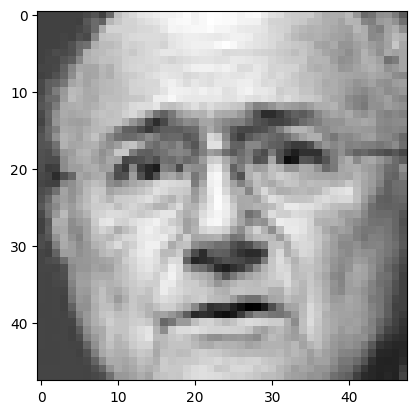

In [19]:
#lets display the image which we want to predict 
import numpy as np
image = X_train[5]
plt.imshow(np.squeeze (image), cmap='gray')
plt.show()

In [20]:
X_test.shape

(3589, 48, 48, 1)

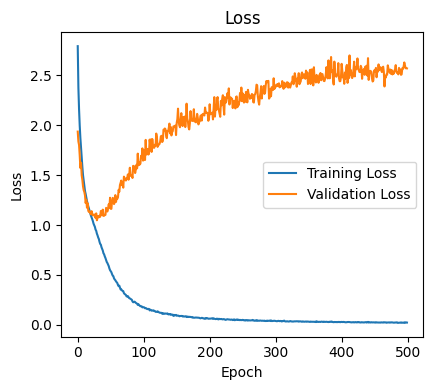

<Figure size 640x480 with 0 Axes>

In [21]:
# Plotting the training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig('Loss.png')

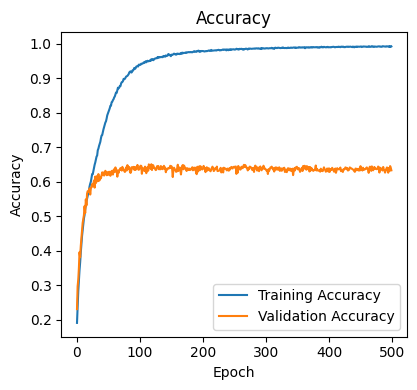

<Figure size 640x480 with 0 Axes>

In [22]:
# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig('Accuracy.png')

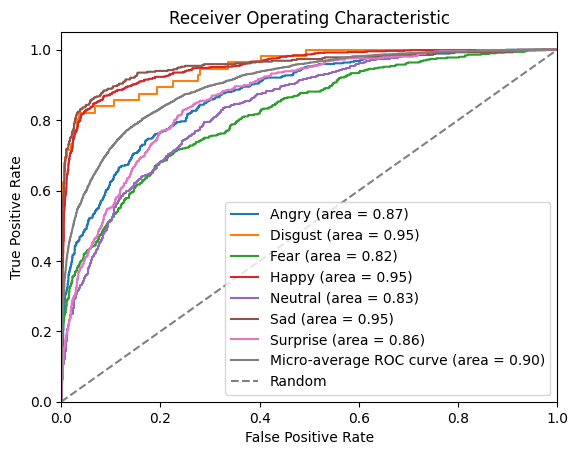

<Figure size 640x480 with 0 Axes>

In [23]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# Convert y_test and y_pred_prob to one-hot encoding
y_test_one_hot = label_binarize(y_test, classes=range(num_classes))

# Calculate the fpr, tpr, and roc_auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_one_hot.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Define the emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Plot ROC curve for each class
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='{} (area = {:.2f})'.format(emotion_labels[i], roc_auc[i]))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {:.2f})'.format(roc_auc["micro"]))

# Plot random curve
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
plt.savefig('ROC-curve.png')

In [24]:
print('Part-2 Complete')

Part-2 Complete


In [ ]:
#Final Code

from keras.models import load_model
from time import sleep
from tensorflow.keras.utils import img_to_array
from keras.preprocessing import image
import cv2
import numpy as np

face_classifier = cv2.CascadeClassifier(r'/content/haarcascade_frontalface_default.xml')
classifier = load_model(r"/content/model.h5")

emotion_labels = ['Angry','Disgust','Fear','Happy','Neutral', 'Sad', 'Surprise']

cap = cv2.VideoCapture(0)



while True:
    _, frame = cap.read()
    labels = []
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray)

    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,255),2)
        roi_gray = gray[y:y+h,x:x+w]
        roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)



        if np.sum([roi_gray])!=0:
            roi = roi_gray.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0)

            prediction = classifier.predict([roi,roi])[0]
            label=emotion_labels[prediction.argmax()]
            label_position = (x,y)
            cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
        else:
            cv2.putText(frame,'No Faces',(30,80),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    cv2.imshow('Emotion Detector',frame)
    if cv2.waitKey(1) ==13 & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

print('Part-3 Complete')